# 4: How to interpret GBM results

Understanding why a model predicts a certain outcome is very important for several reasons, including trust, actionability, accountability, and debugging. 

Insights into the nonlinear relationship between features and the outcome uncovered by the model, as well as interactions among features, are also of value when the goal is to learn more about the underlying drivers of the phenomenon under study.

## Imports & Settings

In [2]:
%matplotlib inline

from pathlib import Path
import warnings
from random import randint

import numpy as np
import pandas as pd

import shap
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice
np.random.seed(42)

In [4]:
DATA_STORE = Path('../data/assets.h5')

## Retrieve best model parameters

In [5]:
with pd.HDFStore('../data.h5') as store:
    best_params = store['best_params']

In [6]:
best_params

train_length         252.0
test_length           63.0
learning_rate          0.1
num_leaves           128.0
feature_fraction       0.6
min_data_in_leaf    1000.0
boost_rounds         250.0
Name: 787, dtype: float64

## Get Training Data

In [7]:
data = pd.read_hdf('../data.h5', 'model_data').sort_index()
data = data.loc[idx[:, '2010':'2022'], :]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 172704 entries, ('ALUA.BA', Timestamp('2010-01-04 00:00:00')) to ('YPFD.BA', Timestamp('2022-12-30 00:00:00'))
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   dollar_vol       172704 non-null  float64
 1   dollar_vol_rank  172704 non-null  float64
 2   rsi              172606 non-null  float64
 3   bb_high          172571 non-null  float64
 4   bb_low           172565 non-null  float64
 5   NATR             172606 non-null  float64
 6   ATR              172606 non-null  float64
 7   ppo              172529 non-null  float64
 8   MACD             172473 non-null  float64
 9   sector           172704 non-null  int64  
 10  r01              172697 non-null  float64
 11  r05              172669 non-null  float64
 12  r10              172634 non-null  float64
 13  r21              172557 non-null  float64
 14  r42              172410 non-null  float64
 15  r6

## Create Binary Data

In [9]:
dates = sorted(data.index.get_level_values('date').unique())

In [10]:
train_dates = dates[-int(best_params.train_length):]

In [11]:
data = data.loc[idx[:, train_dates], :]

In [12]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()

In [13]:
lookahead = 1
label = f'r{lookahead:02}_fwd'

In [14]:
categoricals = ['year', 'month', 'sector', 'weekday']

In [15]:
lgb_train = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

## Train LightGBM Model

In [16]:
params = dict(boosting='gbdt', objective='regression', verbose=-1)

In [17]:
train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

In [18]:
params.update(best_params.loc[train_params].to_dict())
for p in ['min_data_in_leaf', 'num_leaves']:
    params[p] = int(params[p])

In [19]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.1,
 'num_leaves': 128,
 'feature_fraction': 0.6,
 'min_data_in_leaf': 1000}

In [20]:
lgb_model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=int(best_params.boost_rounds))

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero


## Compute Feature Importance

A common approach to gaining insights into the predictions made by tree ensemble methods, such as gradient boosting or random forest models, is to attribute feature importance values to each input variable. These feature importance values can be computed on an individual basis for a single prediction or globally for an entire dataset (that is, for all samples) to gain a higher-level perspective on how the model makes predictions.

There are three primary ways to compute global feature importance values:
- Gain: This classic approach introduced by Leo Breiman in 1984 uses the total reduction of loss or impurity contributed by all splits for a given feature. The motivation is largely heuristic, but it is a commonly used method to select features.
- Split count: This is an alternative approach that counts how often a feature is used to make a split decision, based on the selection of features for this purpose based on the resultant information gain.
- Permutation: This approach randomly permutes the feature values in a test set and measures how much the model's error changes, assuming that an important feature should create a large increase in the prediction error. Different permutation choices lead to alternative implementations of this basic approach.

All gradient boosting implementations provide feature-importance scores after training as a model attribute. The `lightGBM` library provides five versions, as shown in the following list:
- total_gain and gain as its average per split
- total_cover as the number of samples per split when a feature was used
- weight as the split count from preceding values

These values are available using the trained model's .feature_importance() method with the corresponding importance_type parameter. For the best performing XGBoost model, the results are as follows (the total measures have a correlation of 0.8, as do cover and total_cover):

While the indicators for different months and years dominate, the most recent 1m return is the second-most important feature from a total_gain perspective, and is used frequently according to the weight measure, but produces low average gains as it is applied to relatively few instances on average).

In [21]:
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi/fi.sum()

In [22]:
feature_importance = (get_feature_importance(lgb_model).to_frame('Split').
                      join(get_feature_importance(lgb_model, 'gain').to_frame('Gain')))

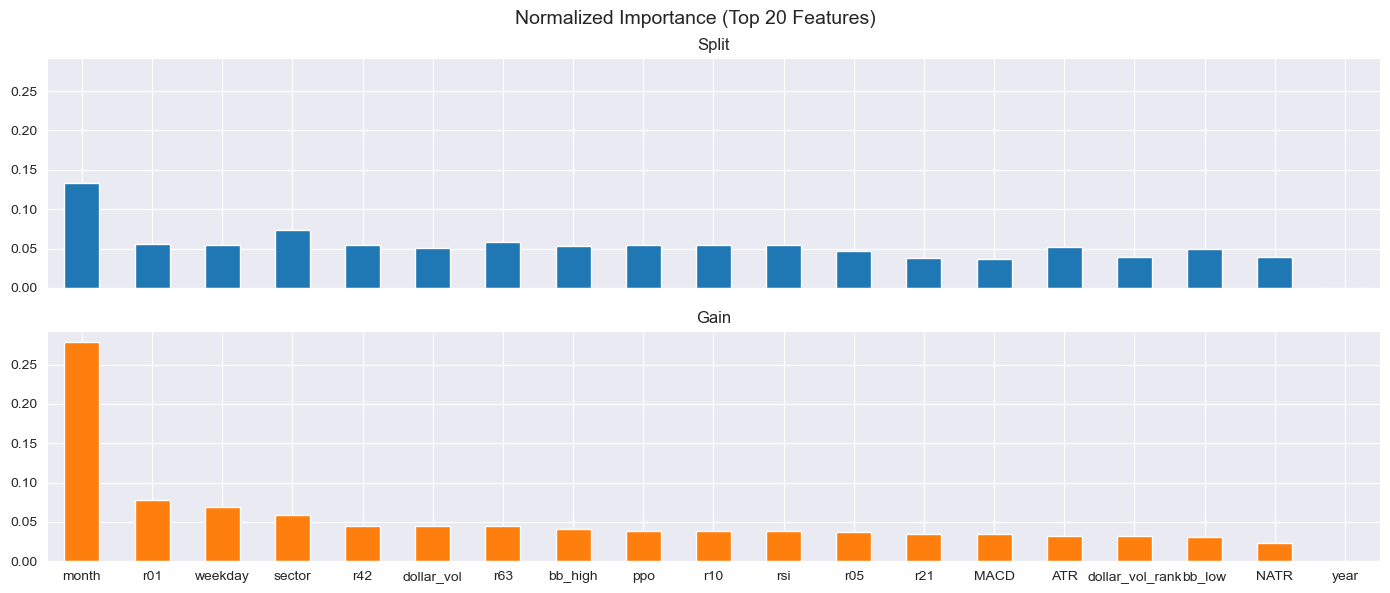

In [23]:
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True,
      layout=(2, 1),
      figsize=(14, 6),
      legend=False,
      sharey=True,
      rot=0))
plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9);

## SHAP Values

We will use another approach to explaining the contribution of individual features to the output of tree ensemble models called [SHapley Additive exPlanations](https://github.com/slundberg/shap), or SHAP values.

### Summary Plot

To get a high-level overview of the feature importance across a number of samples, there are two ways to plot the SHAP values: a simple average across all samples that resembles the global feature-importance measures computed previously (as shown in the second plot), or a scatter graph to display the impact of every feature for every sample (as shown in first plot). 

The scatter plot sorts features by their total SHAP values across all samples, and then shows how each feature impacts the model output as measured by the SHAP value as a function of the feature's value, represented by its color, where red represents high and blue represents low values relative to the feature's range.

They are very straightforward to produce using a trained model of a compatible library and matching input data, as shown in the following code:

In [24]:
X = data[features].sample(n=1000)

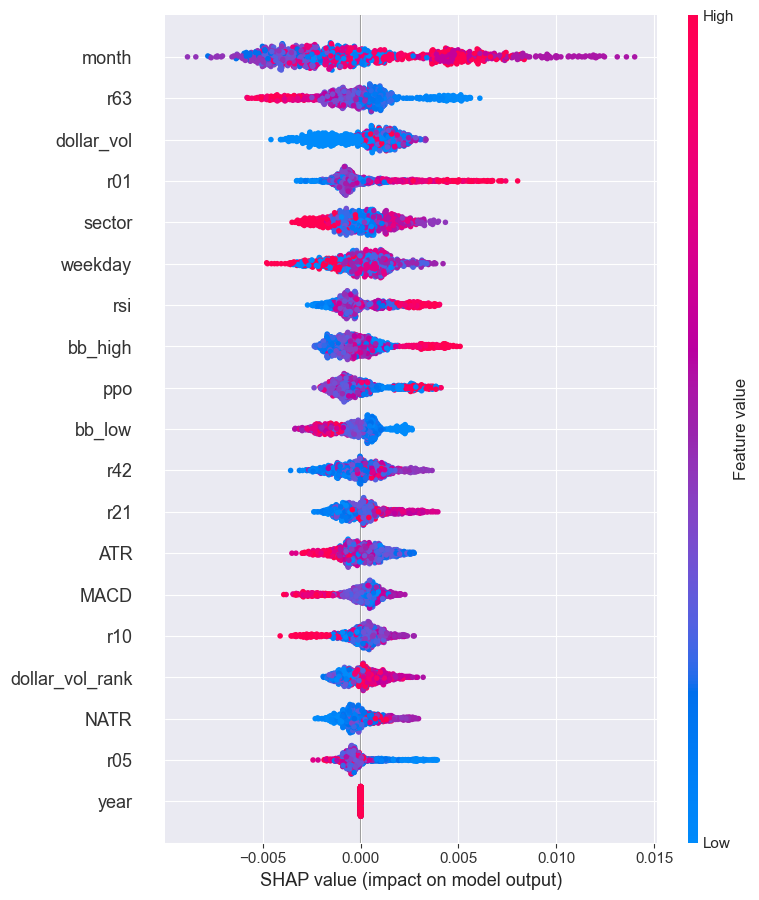

In [25]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X=X)

shap.summary_plot(shap_values, X, show=False)
plt.tight_layout();

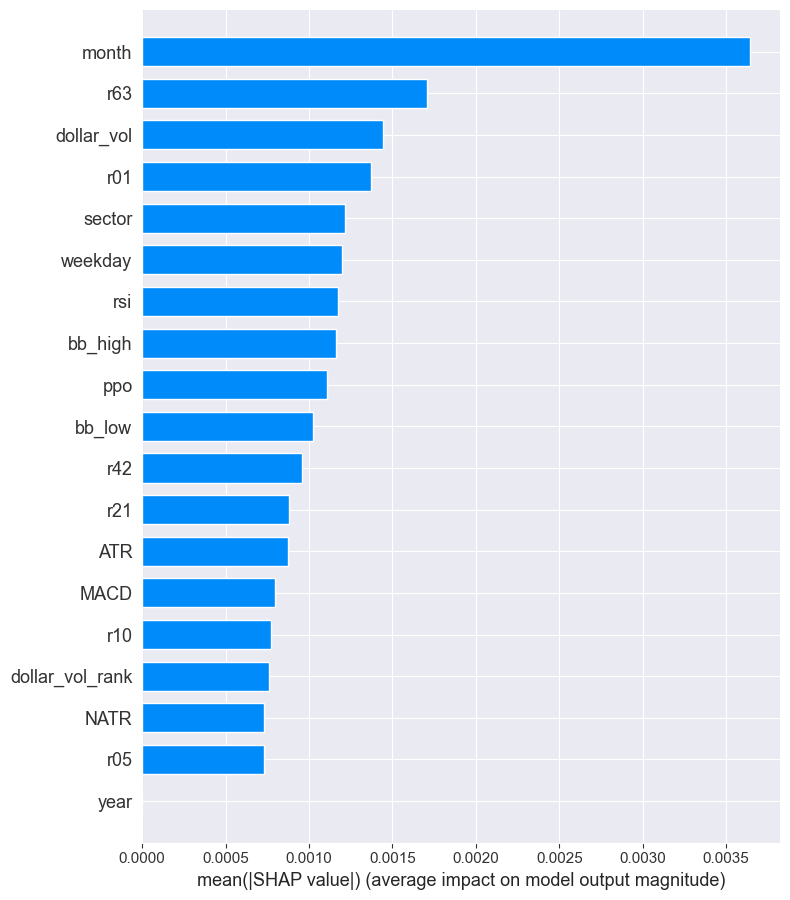

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.tight_layout();

### Feature Interaction

### Force Plots

The following force plot shows the cumulative impact of various features and their values on the model output, which in this case was 0.6, quite a bit higher than the base value of 0.13 (the average model output over the provided dataset). 

Features highlighted in red increase the output. The month being October is the most important feature and increases the output from 0.338 to 0.537, whereas the year being 2017 reduces the output. 

Hence, we obtain a detailed breakdown of how the model arrived at a specific prediction:

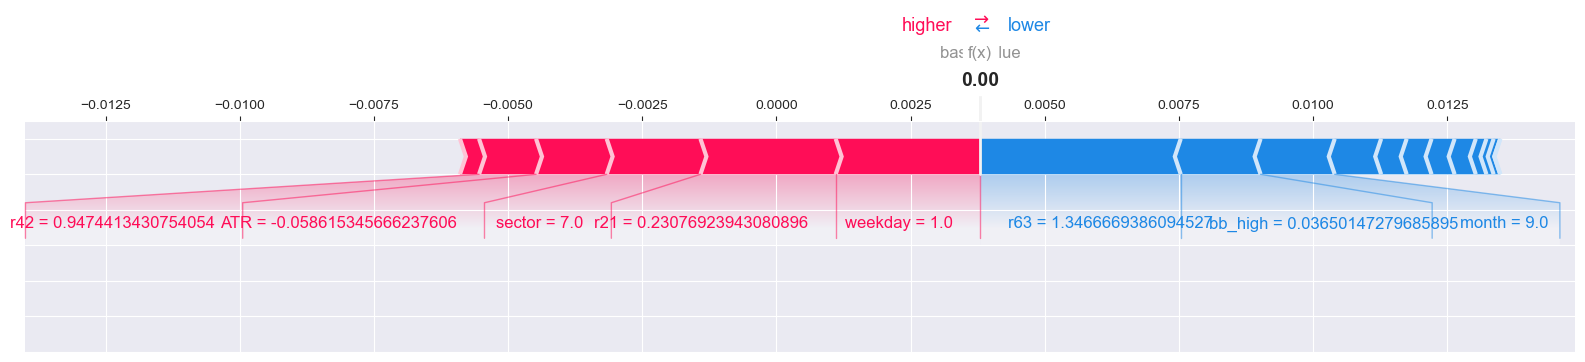

In [27]:
i = randint(0, len(X))
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:], matplotlib=True)


We can also compute force plots for numerous data points or predictions at a time and use a clustered visualization to gain insights into how prevalent certain influence patterns are across the dataset. 

The following plot shows the force plots for the first 1,000 observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation. 

The implementation uses hierarchical agglomerative clustering of data points on the feature SHAP values to identify these patterns, and displays the result interactively for exploratory analysis, as shown in the following code:

In [28]:
force_plot = shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000])

from IPython.display import HTML
HTML(f"<div style='background-color:White;'>{shap.getjs() + force_plot.html()}</div>")

### Interaction Plot

Lastly, SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. The shap.dependence_plot  can be defined as follows. It displays how different values for 1-month returns (on the x axis) affect the outcome (SHAP value on the y axis), differentiated by 3-month returns:

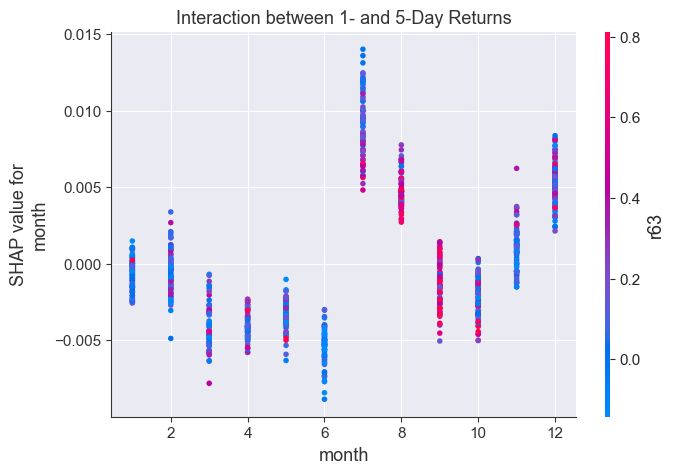

In [34]:
shap.dependence_plot(ind='month',
                     shap_values=shap_values,
                     features=X,
                     interaction_index='r63',
                     title='Interaction between 1- and 5-Day Returns')

SHAP values provide granular feature attribution at the level of each individual prediction, and enable much richer inspection of complex models through (interactive) visualization. The SHAP summary scatterplot displayed at the beginning of this section offers much more differentiated insights than a global feature-importance bar chart. Force plots of individual clustered predictions allow for more detailed analysis, while SHAP dependence plots capture interaction effects and, as a result, provide more accurate and detailed results than partial dependence plots.

The limitations of SHAP values, as with any current feature-importance measure, concern the attribution of the influence of variables that are highly correlated because their similar impact could be broken down in arbitrary ways.